## Spectral Results Inspection

This notebook compares measurements performed on CSP spectra by different team members.

In [1]:
import sys
from pathlib import Path

import numpy as np
import yaml
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.models import HoverTool, Range1d, Span
from bokeh.plotting import ColumnDataSource, figure, show
from matplotlib import pyplot as plt
import scipy.stats as stats
from sndata.csp import DR1
from sndata.sdss import Sako18Spec

from utils import read_in_pipeline_result

sys.path.insert(0, '..')
from scripts.run_csp import pre_process
from spec_analysis.spectra import Spectrum


In [2]:
output_notebook()


Loading BokehJS ...

## Reading In Data

In [3]:
dr1 = DR1()
dr1.download_module_data()

# Project data
results_dir = Path('.').resolve().parent / 'results'
config_path = Path('../app_config.yml')
with config_path.open() as config_file:
    config_data = yaml.load(config_file, Loader=yaml.SafeLoader)


In [4]:
ella = read_in_pipeline_result(results_dir / 'ella_csp.csv', 'csp')
emily = read_in_pipeline_result(results_dir / 'emily_csp.csv', 'csp')
anish = read_in_pipeline_result(results_dir / 'anish_csp.csv', 'csp')

_ella = ella.set_index('time', append=True)
_emily = emily.set_index('time', append=True)
_anish = anish.set_index('time', append=True)
combined = _ella.join(_emily, lsuffix='_ella', rsuffix='_emily')
combined = combined.join(_anish.add_suffix('_anish'))

combined.head()


,,,feat_start_ella,feat_end_ella,vel_ella,vel_err_ella,vel_samperr_ella,pew_ella,pew_err_ella,pew_samperr_ella,area_ella,area_err_ella,...,pew_samperr_anish,area_anish,area_err_anish,area_samperr_anish,notes_anish,phase_anish,spec_type_anish,delta_t_anish,is_peak_anish,branch_type_anish
feat_name,obj_id,time,,,,,,,,,,,,,,,,,,,,,
pW1,2006gt,2454003.75,3675.0045,3931.1794,11362.464822,0.0,61.388286,90.243099,0.0,2.423678,4.861068e-14,0.0,...,2.423678,4.861068e-14,0.0,2.164635e-15,NaN,0.24,91bg-like,0.24,True,CL
pW8,2006gt,2454003.75,7811.6466,8597.6378,11087.042599,0.0,134.524850,280.565605,0.0,13.046939,4.706342e-14,0.0,...,13.046939,4.706342e-14,0.0,3.341364e-15,NaN,0.24,91bg-like,0.24,True,CL
pW7,2006gt,2454003.75,5939.8234,6402.6848,9553.168824,0.0,16.854108,124.350094,0.0,2.493090,4.836447e-14,0.0,...,2.635295,4.817613e-14,0.0,1.334219e-15,NaN,0.24,91bg-like,0.24,True,CL
pW6,2006gt,2454003.75,5587.5829,5934.0012,9103.786649,0.0,11.243609,51.911860,0.0,1.148714,2.109637e-14,0.0,...,1.987738,2.019208e-14,0.0,9.301553e-16,NaN,0.24,91bg-like,0.24,True,CL
pW2,2006gt,2454003.75,3931.1794,4076.7333,8843.677255,0.0,444.836943,17.783829,0.0,1.678227,1.135375e-14,0.0,...,1.678227,1.135375e-14,0.0,1.228104e-15,NaN,0.24,91bg-like,0.24,True,CL


## Comparison with CSP

We compare internal pEW measurements with published values from CSP.

In [5]:
def plot_csp_pew_comparison(pipeline_data):
    """Scatter plot internal pEW measurements against published CSP results
    
    Args:
        pipeline_data (DataFrame): Output data from the analysis pipeline
    """

    # Get pEW measurements from internal team members
    group_data = pipeline_data.groupby('feat_name')

    # Get pEW measurements from DR1
    pub_frame = dr1.load_table(6).to_pandas()
    pub_frame.rename(columns={'SN': 'obj_id'}, inplace=True)
    pub_frame.set_index(['obj_id'], inplace=True)

    fig, axes = plt.subplots(2, 4, figsize=(10, 6))
    axis_limits = {
        'pW1': (50, 200),
        'pW2': (0, 40),
        'pW3': (50, 200),
        'pW4': (50, 250),
        'pW5': (20, 110),
        'pW6': (0, 75),
        'pW7': (50, 160),
        'pW8': (0, 310),
    }

    columns = ['pW1', 'pW2', 'pW3', 'pW4', 'pW5', 'pW6', 'pW7', 'pW8', 'pew']
    for (feat_name, feat_data), axis in zip(group_data, axes.flatten()):
        data_final = feat_data.join(pub_frame)  # Combine measured and published dataframes
        nonan_frame = data_final[columns].dropna()

        slope, intercept, r, p, s = stats.linregress(nonan_frame['pew'], nonan_frame[feat_name])

        axis.scatter(nonan_frame['pew'], nonan_frame[feat_name], marker="x", label=feat_name)
        axis.plot(nonan_frame['pew'], nonan_frame['pew'] * slope + intercept, color='r',
                  label=f'{slope: .2f}x+{intercept: .2f}')

        axis.set_xlim(axis_limits[feat_name])
        axis.legend(loc='upper left')

    fig.text(-0.03, 0.5, "Measured pW [$\AA$]", va='center', rotation='vertical', fontsize=14)
    fig.text(0.52, -0.03, "Published pW [$\AA$]", ha='center', fontsize=14)
    fig.text(0.23, 1, "Measured vs. Published Results for Features in CSP", fontsize=16)
    plt.tight_layout()


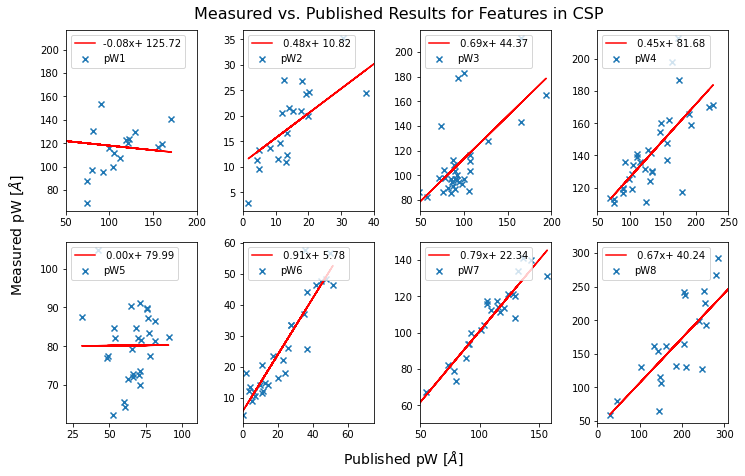

In [6]:
plot_csp_pew_comparison(anish)

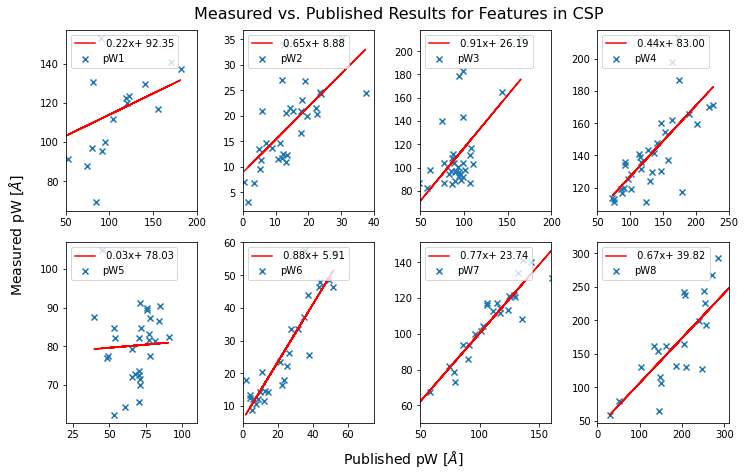

In [7]:
plot_csp_pew_comparison(emily)

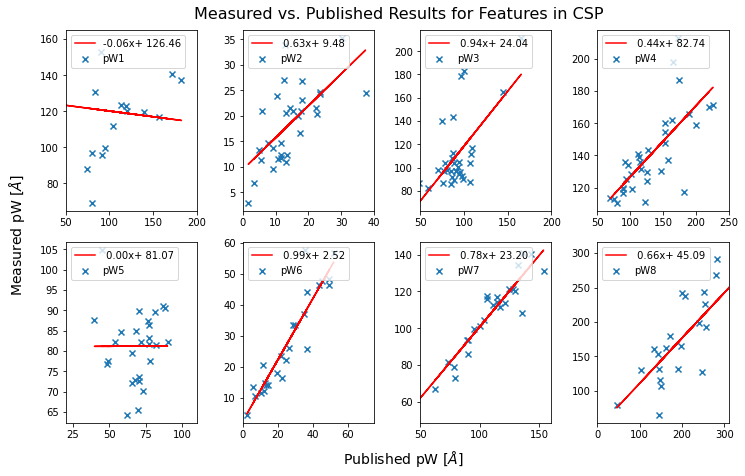

In [8]:
plot_csp_pew_comparison(ella)

## pEW Comparison Between Team Members

We compare pseudo pEW measurements between different team members.

In [9]:
def data_to_plot(set1, set2, feat):
    """return pew values for 2 people for a given feature
    
    Parameters:
        set1: first person to compare
        set2: second person to compare
        feat: feature name (ex. pW1)
    
    Returns:
        set1_data: list of measurements
        set2_data: list of measurements
    """

    set1 = set1.reset_index()
    set2 = set2.reset_index()
    
    if feat == 'all':
        set1_feat = set1
        set2_feat = set2
        
    else:
        # identifying only rows with a specific feature measurement
        set1_feat = set1[set1['feat_name'] == feat]
        set2_feat = set2[set2['feat_name'] == feat]

    # setting indices to shared values
    set1_feat2 = set1_feat.set_index(['obj_id', 'time', 'feat_name'])
    set2_feat2 = set2_feat.set_index(['obj_id', 'time', 'feat_name'])

    # combining the two tables
    combined_table = set1_feat2.join(set2_feat2, lsuffix=f'{set1}', rsuffix=f'{set2}')

    # dropping NaNs, i.e. rows without shared measurements
    final_table = combined_table.dropna(subset=[f'pew{set1}', f'pew{set2}'])

    # data to be plotted
    set1_data = final_table[f'pew{set1}']
    set2_data = final_table[f'pew{set2}']

    return set1_data, set2_data


In [10]:
def bounds_finder(set1, set2, feat):
    """find mininum and maximum for data to be plotted
    
    Parameters:
        set1: first person data
        set2: second person data
    
    Returns:
        min_bound: lower bound of data
        max_bound: upper bound of data
    """

    data1, data2 = data_to_plot(set1, set2, feat)

    min1 = np.min(data1)
    min2 = np.min(data2)

    max1 = np.max(data1)
    max2 = np.max(data2)

    if min1 <= min2:
        min_bound = min1
    else:
        min_bound = min2

    if max1 >= max2:
        max_bound = max1
    else:
        max_bound = max2

    return min_bound, max_bound


In [11]:
def compare_internal_pew(features=None):
    """plot the 3 sets of comparisons for all 8 features
    
    Args:
        features: Optionally plot only a subset of features
    """

    features = features or (f'pW{i}' for i in range(1, 9))
    for feat_name in features:
        # getting the data to be plotted in each figure
        ella_fig1, emily_fig1 = data_to_plot(ella, emily, feat_name)

        emily_fig2, anish_fig2 = data_to_plot(emily, anish, feat_name)

        anish_fig3, ella_fig3 = data_to_plot(anish, ella, feat_name)

        # data to plot the line y=x, goes from the minimum measurement in all three sets to the maximum (roughly)
        x = np.arange(-60, 450)

        # creating the figure
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5), sharex=False)
        fig.suptitle(f'{feat_name} Comparison')

        # plotting the leftmost figure
        min1, max1 = bounds_finder(ella, emily, feat_name)

        ax1.scatter(ella_fig1, emily_fig1)
        ax1.plot(x, x, color='black', linestyle='--')
        ax1.set_xlim(min1, max1)
        ax1.set_ylim(min1, max1)
        ax1.set_xlabel("Ella's Measurements")
        ax1.set_ylabel("Emily's Measurements")

        # plotting the middle figure
        min2, max2 = bounds_finder(emily, anish, feat_name)

        ax2.scatter(emily_fig2, anish_fig2, c='green')
        ax2.plot(x, x, color='black', linestyle='--')
        ax2.set_ylim(min2, max2)
        ax2.set_xlim(min2, max2)
        ax2.set_xlabel("Emily's Measurements")
        ax2.set_ylabel("Anish's Measurements")

        # plotting the rightmost figure
        min3, max3 = bounds_finder(anish, ella, feat_name)

        ax3.scatter(anish_fig3, ella_fig3, c='red')
        ax3.plot(x, x, color='black', linestyle='--')
        ax3.set_ylim(min3, max3)
        ax3.set_xlim(min3, max3)
        ax3.set_xlabel("Anish's Measurements")
        ax3.set_ylabel("Ella's Measurements")


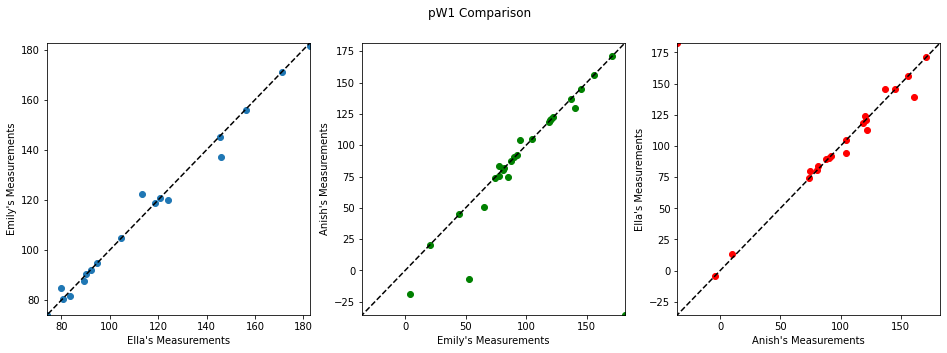

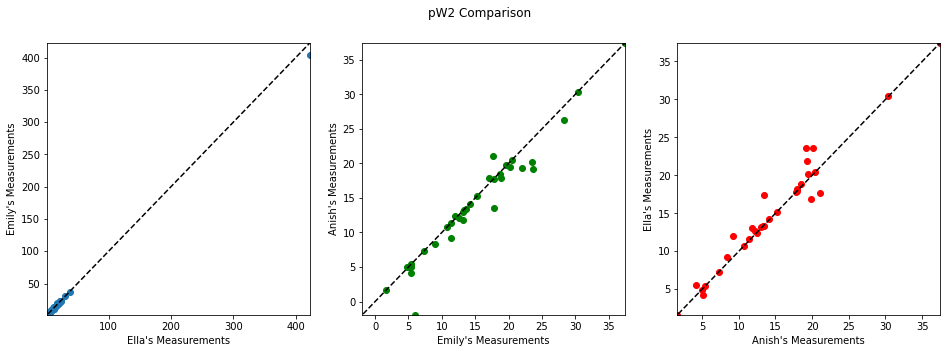

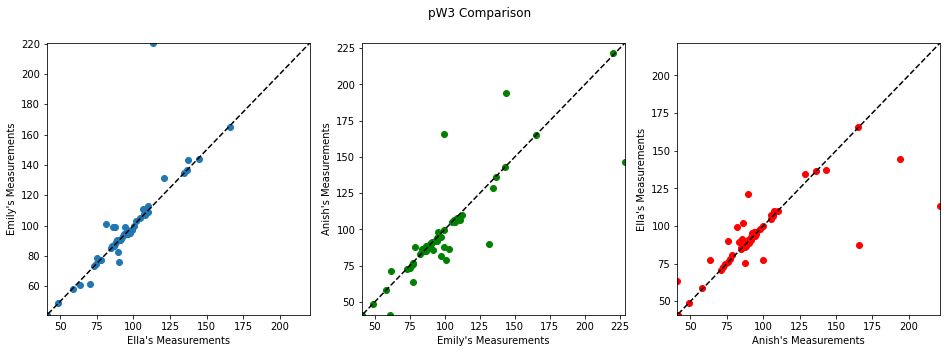

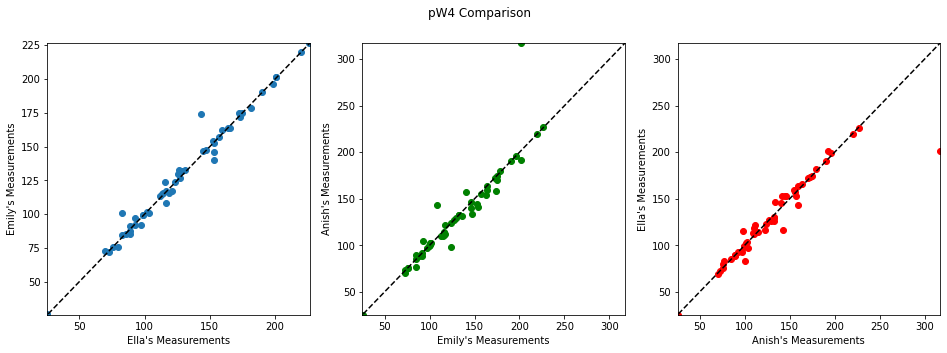

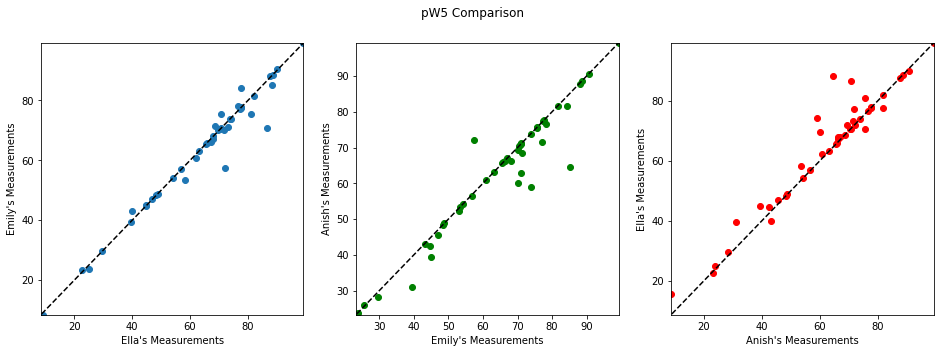

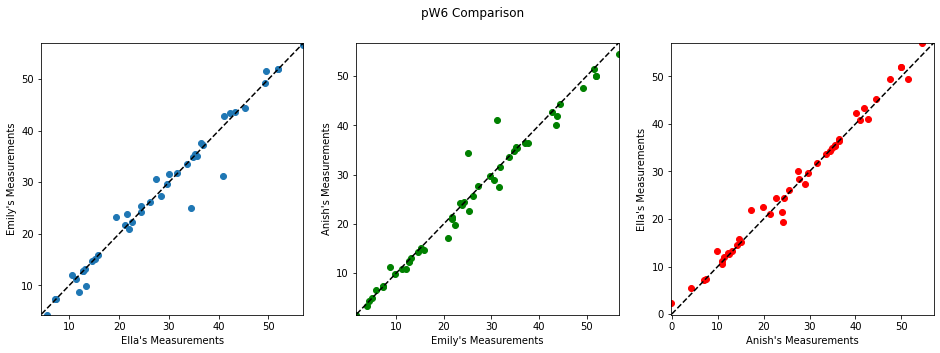

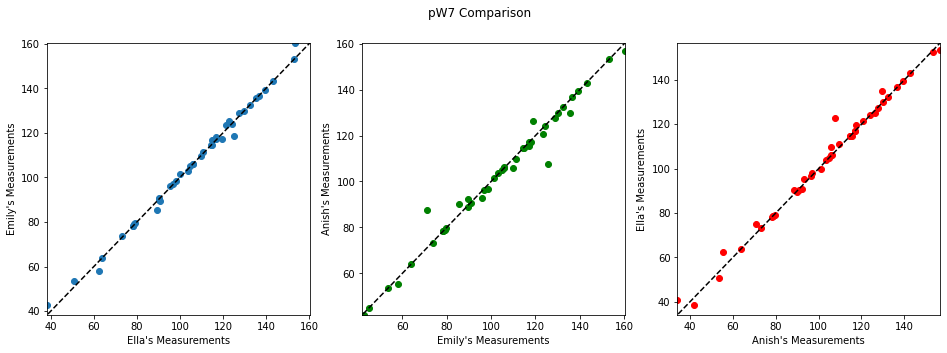

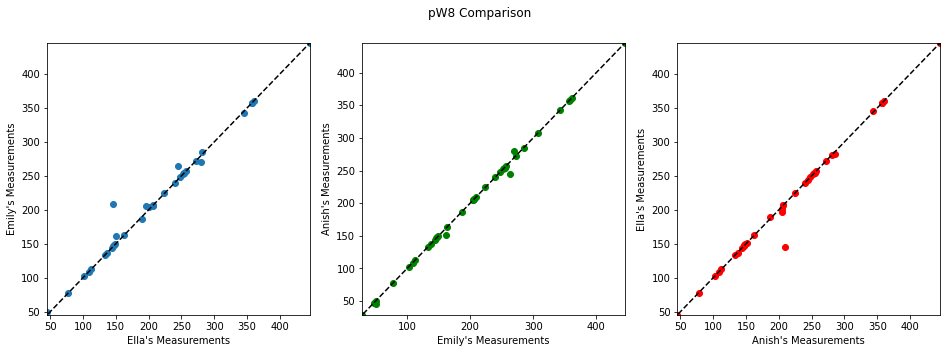

In [12]:
compare_internal_pew()


In [13]:
def compare_all_pew_measurements():
    """Plot a comparison of pEW values for all SNe"""

    ax1_x, ax1_y = data_to_plot(ella, emily, 'all')
    ax2_x, ax2_y = data_to_plot(emily, anish, 'all')
    ax3_x, ax3_y = data_to_plot(anish, ella, 'all')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    ax1.scatter(ax1_x, ax1_y, alpha=.4)
    ax2.scatter(ax2_x, ax2_y, alpha=.4)
    ax3.scatter(ax3_x, ax3_y, alpha=.4)
    
    for ax in (ax1, ax2, ax3):
        bounds = [0, 500]
        ax.plot(bounds, bounds, color='k', linestyle='--')
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)
        
    ax1.set_xlabel("Ella's Measurements")
    ax1.set_ylabel("Emily's Measurements")

    ax2.set_xlabel("Emily's Measurements")
    ax2.set_ylabel("Anish's Measurements")

    ax3.set_xlabel("Anish's Measurements")
    ax3.set_ylabel("Ella's Measurements")
    
    fig.suptitle('All pEW Measurements')
    plt.tight_layout()
    


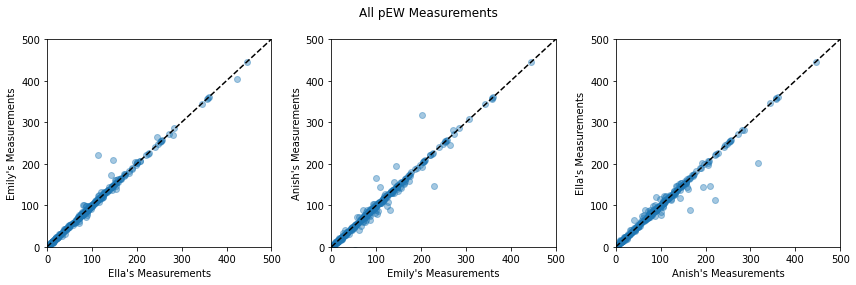

In [14]:
compare_all_pew_measurements()


In [15]:
def plot_branch_classification_comparison(combined_data):
    
    pw6 = combined_data.loc['pW6']
    pw7 = combined_data.loc['pW7']
    joined = pw6.join(pw7, lsuffix='_pw6', rsuffix='_pw7')
    source_em = ColumnDataSource(joined.reset_index())

    hover = HoverTool(
        tooltips=[
            ('index', '$index'),
            ('(x,y)', '($x, $y)'),
            ('desc', '@obj_id'),
        ]
    )

    fig = figure(plot_width=900, plot_height=800, title='pw6 vs pw7')
    fig.tools.append(hover)

    fig.circle('pew_anish_pw7', 'pew_anish_pw6', size=5, source=source_em, color='red', legend_label='Anish')
    fig.circle('pew_ella_pw7', 'pew_ella_pw6', size=5, source=source_em, color='green', legend_label='Ella')
    fig.circle('pew_emily_pw7', 'pew_emily_pw6', size=5, source=source_em, color='blue', legend_label='Emily')

    fig.legend.location = 'top_left'
    fig.legend.click_policy = 'hide'
    fig.xaxis.axis_label = 'pw7'
    fig.yaxis.axis_label = 'pw6'
    show(fig)


In [16]:
plot_branch_classification_comparison(combined)


## Feature Boundary Selection

In [17]:
def compare_boundary_selection(obj_id, time, feature, results=combined):
    """Plot an interactive comparison of estimated feature boundaries
    
    Args:
        obj_id        (str): The object to plot
        time        (float): Observation time of the desired object's spectrum
        feature       (str): Name of the feature to inspect (e.g., 'pW1')
        results (DataFrame): Dataframe of inspection results
    """

    # Load object data
    data = dr1.get_data_for_id(obj_id)
    processed_data = pre_process(data)
    processed_data = processed_data[processed_data['time'] == time]
    spectrum = Spectrum(
        processed_data['wavelength'],
        processed_data['flux'],
        processed_data.meta['ra'],
        processed_data.meta['dec'],
        processed_data.meta['z'],
    )
    spectrum.prepare_spectrum(bin_size=10)

    # Create a seperate subplot for each inspector
    sub_size = (800, 400)
    title = f'{obj_id} - {time} - {feature}'
    s1 = figure(plot_width=sub_size[0], plot_height=sub_size[1], title=title)
    s2 = figure(plot_width=sub_size[0], plot_height=sub_size[1], x_range=s1.x_range, y_range=s1.y_range)
    s3 = figure(plot_width=sub_size[0], plot_height=sub_size[1], x_range=s1.x_range, y_range=s1.y_range)

    # Instantiate plotting args
    inspectors = ('ella', 'emily', 'anish')
    obj_results = results.loc[feature, obj_id, time]
    lower_blue = config_data['features'][feature]['lower_blue']
    upper_blue = config_data['features'][feature]['upper_blue']
    lower_red = config_data['features'][feature]['lower_red']
    upper_red = config_data['features'][feature]['upper_red']

    for fig, insp in zip((s1, s2, s3), inspectors):
        # Format figure
        fig.yaxis.axis_label = insp.title()
        fig.y_range = Range1d(0, 1.1 * max(spectrum.rest_flux))

        # Plot object data and auto boundaries
        fig.line(spectrum.rest_wave, spectrum.rest_flux, alpha=0.3, color='black')
        fig.line(spectrum.rest_wave, spectrum.bin_flux, alpha=0.8, color='black')
        fig.harea([lower_blue, lower_blue], [upper_blue, upper_blue], [-1, 2], alpha=.1)
        fig.harea([lower_red, lower_red], [upper_red, upper_red], [-1, 2], alpha=.1, color='red')

        measured_start = obj_results[f'feat_start_{insp}']
        measured_end = obj_results[f'feat_end_{insp}']
        if np.isnan(measured_start):
            continue

        vline1 = Span(location=measured_start, dimension='height', line_color='red', line_width=1)
        vline2 = Span(location=measured_end, dimension='height', line_color='red', line_width=1)
        fig.renderers.extend([vline1, vline2])

    p = gridplot([[s1], [s2], [s3]])
    show(p)


In [18]:
compare_boundary_selection('2004ef', 2453255.66, 'pW2')
